In [1]:

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn import linear_model
from icet import ClusterSpace
from ase.visualize import view
from ase.db import connect
import ase
import icet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.gridspec import GridSpec
import emcee
import corner
from scipy.stats import gamma, invgamma, t, norm, norminvgauss, mode
import seaborn as sns
sns.set_context("paper", font_scale=1.5)
sns.set_style("darkgrid")
sns.set_palette("deep")
sns.set(font='sans-serif')
%matplotlib inline
plt.rcParams['figure.dpi'] = 140

np.random.seed(123)


 # Project 2a: Alloy cluster expansions
 ### *Sebastian Holmin, Erik Andersson, 2020*
 # Task 1: Collect and plot the data (0.5p)

In [3]:

db = connect('structures/reference_data.db')
for i, row in enumerate(db.select()):
    atoms = row.toatoms()
    E_mix = row.mixing_energy
    print(i, row.symbols, E_mix)
    if(i == 3):
        view(atoms)


0 ['Ag'] 0.0
1 ['Pd'] 0.0
2 ['Pd', 'Ag', 'Ag'] -48.52944333333342
3 ['Pd', 'Ag', 'Ag', 'Ag'] -45.874665000000036
4 ['Ag', 'Pd', 'Pd', 'Pd'] -16.167872499999845
5 ['Pd', 'Ag', 'Ag', 'Ag'] -36.85152999999997
6 ['Pd', 'Pd', 'Ag', 'Ag'] -42.7574974999998
7 ['Ag', 'Pd', 'Pd', 'Pd'] -15.070122499999838
8 ['Pd', 'Pd', 'Ag', 'Ag'] -52.015062499999985
9 ['Pd', 'Ag', 'Ag', 'Ag'] -52.61482750000002
10 ['Ag', 'Pd', 'Pd', 'Pd', 'Pd'] -15.205004000000244
11 ['Ag', 'Pd', 'Ag', 'Pd', 'Pd'] -41.73470399999979
12 ['Pd', 'Pd', 'Ag', 'Ag', 'Ag'] -23.643027999999955
13 ['Ag', 'Pd', 'Ag', 'Pd', 'Pd'] -34.070865999999754
14 ['Ag', 'Ag', 'Pd', 'Pd', 'Pd'] -37.9466399999997
15 ['Ag', 'Pd', 'Ag', 'Pd', 'Pd'] -40.253777999999855
16 ['Pd', 'Ag', 'Ag', 'Ag', 'Ag'] -39.60936800000003
17 ['Pd', 'Pd', 'Ag', 'Ag', 'Ag'] -60.33398999999995
18 ['Pd', 'Ag', 'Pd', 'Ag', 'Ag'] -54.565450000000126
19 ['Ag', 'Ag', 'Pd', 'Pd', 'Pd'] -28.14611999999972
20 ['Pd', 'Pd', 'Ag', 'Ag', 'Ag'] -34.45772000000002
21 ['Pd', 'Ag', 'Pd', 

144 ['Pd', 'Pd', 'Ag', 'Ag', 'Pd', 'Ag', 'Ag', 'Ag'] -54.67907499999991
145 ['Pd', 'Pd', 'Pd', 'Ag', 'Ag', 'Pd', 'Ag', 'Ag'] -48.18698999999982
146 ['Pd', 'Pd', 'Ag', 'Ag', 'Ag', 'Ag', 'Ag', 'Ag'] -44.25757750000003
147 ['Pd', 'Ag', 'Ag', 'Ag', 'Ag', 'Ag', 'Ag', 'Ag'] -26.703466249999973
148 ['Pd', 'Pd', 'Ag', 'Ag', 'Pd', 'Ag', 'Ag', 'Ag'] -53.186882499999925
149 ['Pd', 'Pd', 'Ag', 'Pd', 'Pd', 'Ag', 'Ag', 'Ag'] -42.91636249999997
150 ['Ag', 'Pd', 'Ag', 'Pd', 'Pd', 'Pd', 'Pd', 'Pd'] -19.957179999999795
151 ['Ag', 'Ag', 'Pd', 'Pd', 'Ag', 'Pd', 'Pd', 'Pd'] -32.58777375
152 ['Pd', 'Pd', 'Pd', 'Ag', 'Ag', 'Ag', 'Ag', 'Ag'] -38.5002137499999
153 ['Pd', 'Pd', 'Pd', 'Ag', 'Ag', 'Pd', 'Ag', 'Ag'] -47.71994749999986
154 ['Pd', 'Pd', 'Ag', 'Pd', 'Ag', 'Pd', 'Ag', 'Ag'] -51.53593624999986
155 ['Ag', 'Ag', 'Ag', 'Pd', 'Pd', 'Pd', 'Pd', 'Pd'] -27.21719999999994
156 ['Pd', 'Pd', 'Ag', 'Pd', 'Ag', 'Ag', 'Ag', 'Ag'] -46.89331875000002
157 ['Ag', 'Pd', 'Pd', 'Pd', 'Pd', 'Pd', 'Pd', 'Pd'] -10.29400124999

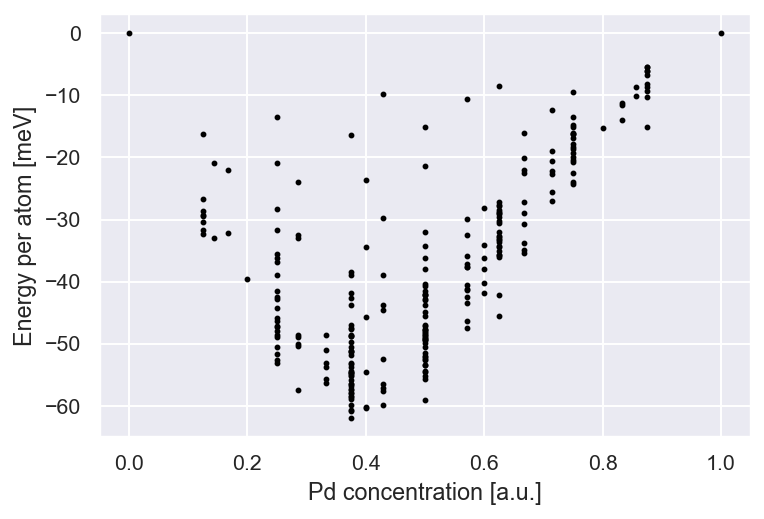

In [4]:
E_mix_list = []
Pd_desity_list = []
for i, row in enumerate(db.select()):
    atoms = row.toatoms()
    atomic_numbers = atoms.get_atomic_numbers()
    E_mix = row.mixing_energy
    Pd_desity_list.append(sum(atomic_numbers == 46)/len(atomic_numbers))
    E_mix_list.append(E_mix)
plt.scatter(Pd_desity_list, E_mix_list, 4, 'black')
plt.xlabel('Pd concentration [a.u.]')
plt.ylabel('Energy per atom [meV]')

plt.savefig('energy_vs_Pd_cons.pdf')


In [5]:
atomic_numbers = atoms.get_atomic_numbers()
print(sum(atomic_numbers == 46)/len(atomic_numbers))



0.5


 Task 2: Cutoff selection for a pair cluster-expansion  (5p)

In [6]:


x = []

# setup CS
cutoffs = [8]
prim = db.get(1).toatoms()
cs = ClusterSpace(prim, cutoffs=cutoffs, chemical_symbols=['Ag', 'Pd'])

for i, row in enumerate(db.select()):
    # get cluster-vector for a given atoms object
    atoms = row.toatoms()
    x.append(cs.get_cluster_vector(atoms))

x = np.array(x)
print(x.shape)


(251, 9)


In [7]:


def run_OLS_fit(A, y):
    ols = linear_model.LinearRegression(fit_intercept=False)
    ols.fit(A, y)
    return ols.coef_


def compute_mse(A, y, parameters):
    y_predicted = np.dot(A, parameters)
    dy = y - y_predicted
    mse = np.mean(dy**2)
    return mse


def compute_rmse(A, y, parameters):
    return np.sqrt(compute_mse(A, y, parameters))


def get_aic_bic(A, y, parameters):

    n_samples = len(y)
    n_parameters = len(parameters)
    mse = compute_mse(A, y, parameters)

    aic = n_samples * np.log(mse) + 2 * n_parameters
    bic = n_samples * np.log(mse) + n_parameters * np.log(n_samples)

    return -aic, -bic


def run_cv(A, y):
    cv = KFold(n_splits=10, shuffle=True, random_state=42)
    rmse_train = []
    rmse_test = []
    for train_inds, test_inds in cv.split(A):
        A_train = A[train_inds]
        y_train = y[train_inds]
        A_test = A[test_inds]
        y_test = y[test_inds]

        parameters = run_OLS_fit(A_train, y_train)
        rmse_train.append(compute_rmse(A_train, y_train, parameters))
        rmse_test.append(compute_rmse(A_test, y_test, parameters))

    data = dict()
    data['rmse_train'] = np.mean(rmse_train)
    data['rmse_train_std'] = np.std(rmse_train)
    data['rmse_validation'] = np.mean(rmse_test)
    data['rmse_validation_std'] = np.std(rmse_test)
    return data


def full_analysis(A, y):

    # run cv
    cv_data = run_cv(A, y)

    # final fit
    parameters = run_OLS_fit(A, y)
    print(np.std(parameters))
    # compute AIC/BIC
    aic, bic = get_aic_bic(A, y, parameters)

    # finalize data
    data = dict(aic=aic, bic=bic)
    data.update(cv_data)
    return data



In [8]:
# generate data
np.random.seed(42)
cutoffs = [[1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12]]
cutoffs = [[x] for x in range(1, 20)]
data_list = []

aic_list = []
bic_list = []
rmse_train_list = []
rmse_valid_list = []
std_train_list = []
std_valid_list = []
mse_list = []

for cutoff in cutoffs:
    print('Cutoff= ', cutoff[0])
    x = []

    # setup CS
    # cutoffs = [8]
    prim = db.get(1).toatoms()
    cs = ClusterSpace(prim, cutoffs=cutoff, chemical_symbols=['Ag', 'Pd'])

    for i, row in enumerate(db.select()):
        # get cluster-vector for a given atoms object
        atoms = row.toatoms()
        x.append(cs.get_cluster_vector(atoms))

    x = np.array(x)
    if cutoff[0] == 6:
        print('NUM PARAMETERS AT 6Å', x.shape[1])
    # N, M = 200, 100
    A = x
    # parameters_true = np.random.normal(0, 1, (M, ))
    # noise = np.random.normal(0, 0.05, (N, ))
    y = np.array(E_mix_list)

    # OLS fit
    data = full_analysis(A, y)
    data_list.append(data)
    # for key, val in data.items():
    #     print(f'{key:20} : {val:11.5f}')
    # print('-----------------------\n')

    aic_list.append(data.get('aic'))
    bic_list.append(data.get('bic'))
    rmse_train_list.append(data.get('rmse_train'))
    rmse_valid_list.append(data.get('rmse_validation'))
    std_train_list.append(data.get('rmse_train_std'))
    std_valid_list.append(data.get('rmse_validation_std'))

    parameters = run_OLS_fit(A, y)
    mse = compute_mse(A, y, parameters)
    mse_list.append(mse)

Cutoff=  1
7.712882269002483
Cutoff=  2
7.712882269002483
Cutoff=  3
34.45049427436012
Cutoff=  4
34.45049427436012
Cutoff=  5
29.98780844432431
Cutoff=  6
NUM PARAMETERS AT 6Å 6
24.06976029148306
Cutoff=  7
22.47883105731934
Cutoff=  8
20.149455844444635
Cutoff=  9
17.336433241934625
Cutoff=  10
16.07894522910112
Cutoff=  11
14.81767374320228
Cutoff=  12
13.444470382408735
Cutoff=  13
12.059109815132636
Cutoff=  14
11.421525642747556
Cutoff=  15
10.575277240044423
Cutoff=  16
9.934347632791454
Cutoff=  17
9.056490817441471
Cutoff=  18
8.611411291896042
Cutoff=  19
14.500157831226536


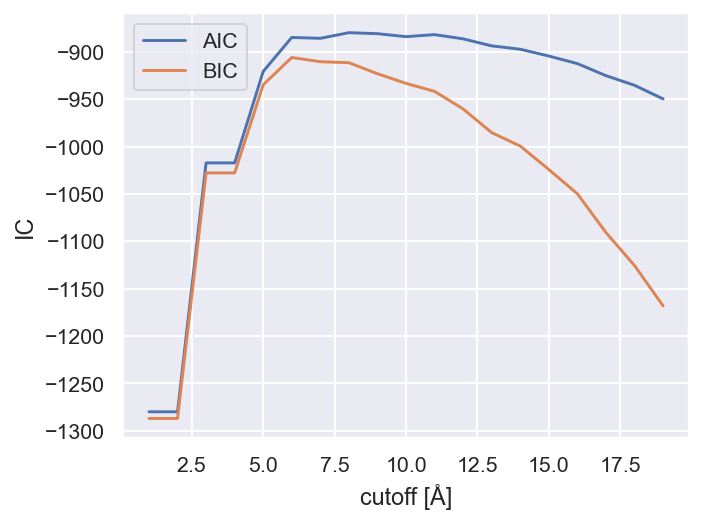

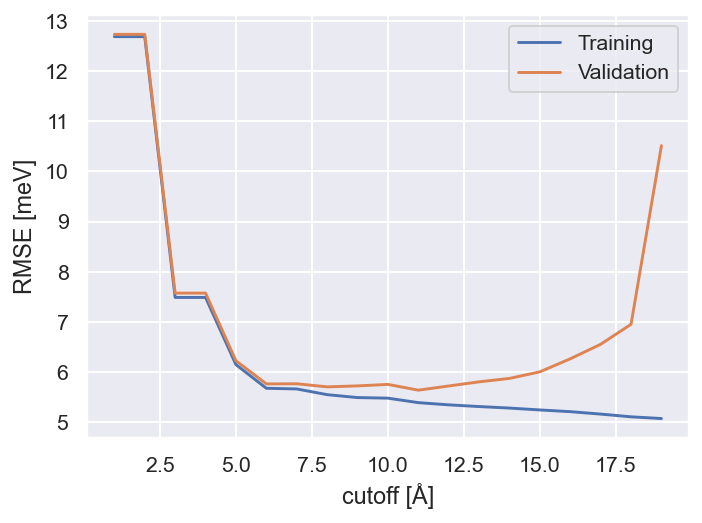

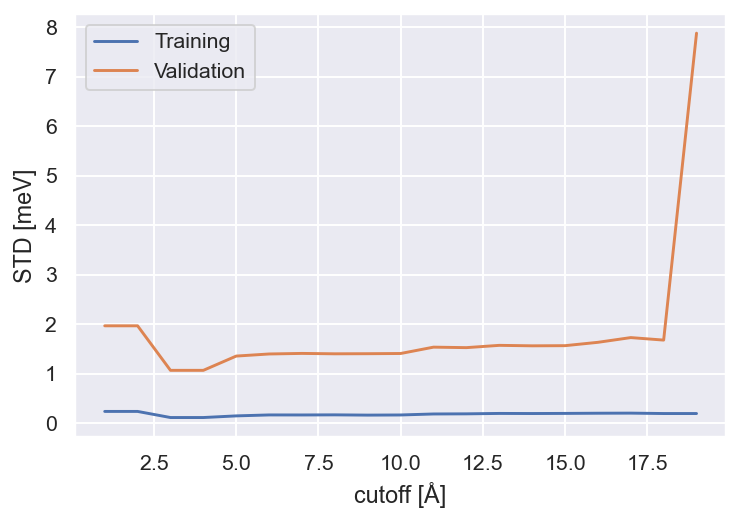

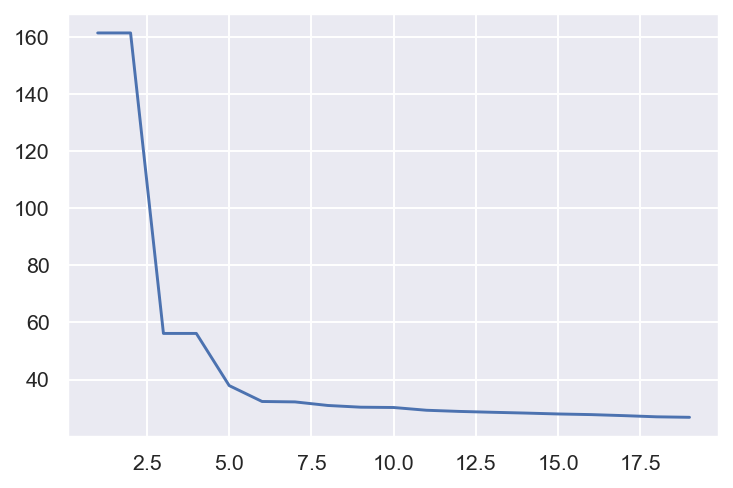

In [9]:

fig_IC = plt.figure(figsize=(6.4*0.8, 4.8*0.8))
plt.plot(cutoffs, aic_list, label='AIC')
plt.plot(cutoffs, bic_list, label='BIC')


plt.xlabel('cutoff [Å]')
plt.ylabel('IC')
plt.legend()
plt.tight_layout()
plt.savefig('cutoff_IC.pdf')

fig_rmse = plt.figure(figsize=(6.4*0.8, 4.8*0.8))
plt.plot(cutoffs, rmse_train_list, label='Training')
plt.plot(cutoffs, rmse_valid_list, label='Validation')

plt.xlabel('cutoff [Å]')
plt.ylabel('RMSE [meV]')
plt.legend()
plt.tight_layout()
plt.savefig('cutoff_RMSE.pdf')

fig_std = plt.figure()
plt.plot(cutoffs, std_train_list, label='Training')
plt.plot(cutoffs, std_valid_list, label='Validation')

plt.xlabel('cutoff [Å]')
plt.ylabel('STD [meV]')
plt.legend()

fig_mse = plt.figure('MSE')
plt.plot(cutoffs, mse_list)

 Task 3:  Feature selection  (5p)

In [10]:
scaler = StandardScaler()
scaler.fit(x)
print(np.std(x, axis=0))
x_stand = scaler.transform(x)
print(np.std(x_stand, axis=0))
print(np.mean(x_stand, axis=0))

[0.         0.38399115 0.26763654 0.357849   0.23006558 0.32542258
 0.23103986 0.41238577 0.22598732 0.44941478 0.2745863  0.23331905
 0.30416628 0.23388045 0.32004412 0.24946843 0.2189898  0.22241591
 0.37641489 0.25742412 0.24438723 0.41881258 0.32058789 0.24569557
 0.23249406 0.32890107 0.22637552 0.39630703 0.21631675 0.51922716
 0.3209492  0.27188356 0.22686008 0.31937865 0.25146915 0.25755185
 0.23117932 0.30776424 0.26891538 0.2299379  0.2422104  0.51861154
 0.24420889 0.25298395 0.23473832 0.32490422 0.33495841 0.22127782
 0.3935779  0.33461042 0.26363714 0.23678361 0.22885789 0.39934081
 0.2420476  0.42097586 0.24470408 0.24999853 0.30636358 0.24629684
 0.24928129 0.22574156]
[0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[ 0.00000000e+00  1.76817392e-16 -2.02582528e-16 -2.27352444e-16
 -4.60012727e-17 -1.89312930e-16  5.68823430e-16  5

In [11]:


def run_cv_Lasso(A, y, alpha):
    cv = KFold(n_splits=10, shuffle=True, random_state=42)
    rmse_train = []
    rmse_test = []

    lasso = linear_model.Lasso(alpha=alpha, fit_intercept=False)

    for train_inds, test_inds in cv.split(A):
        A_train = A[train_inds]
        y_train = y[train_inds]
        A_test = A[test_inds]
        y_test = y[test_inds]

        lasso.fit(A_train, y_train)
        parameters = lasso.coef_

        rmse_train.append(compute_rmse(A_train, y_train, parameters))
        rmse_test.append(compute_rmse(A_test, y_test, parameters))

    data = dict()
    data['rmse_train'] = np.mean(rmse_train)
    data['rmse_train_std'] = np.std(rmse_train)
    data['rmse_validation'] = np.mean(rmse_test)
    data['rmse_validation_std'] = np.std(rmse_test)
    return data


def get_aic_bic_sparse(A, y, parameters):

    n_samples = len(y)
    n_parameters = sum(parameters != 0)
    mse = compute_mse(A, y, parameters)

    aic = n_samples * np.log(mse) + 2 * n_parameters
    bic = n_samples * np.log(mse) + n_parameters * np.log(n_samples)

    return -aic, -bic



In [12]:
alpha_list = np.linspace(0.2, 10, 100)

aic_list = []
bic_list = []
rmse_train_list = []
rmse_valid_list = []
std_train_list = []
std_valid_list = []
mse_list = []
nbr_params_list = []

y_stand = y
# y_stand=(y-np.mean(y))/np.std(y)
# A_stand=(x-np.mean(y))/np.std(y)

A = x_stand

save_params = []

for alpha in alpha_list:

    # print(sum(params!=0))

    cv_data = run_cv_Lasso(A, y_stand, alpha)

    lasso = linear_model.Lasso(alpha=alpha, fit_intercept=False)
    lasso.fit(A, y_stand)
    params = lasso.coef_
    aic, bic = get_aic_bic_sparse(A, y_stand, params)

    nbr_params_list.append(sum(params != 0))

    if sum(params != 0) == 4:
        # save_params.append(np.where(params!=0))
        save_params.append(params[1:5])

    print(np.std(scaler.transform(params.reshape(1, 62))))
    aic_list.append(aic)
    bic_list.append(bic)
    rmse_train_list.append(cv_data.get('rmse_train'))
    rmse_valid_list.append(cv_data.get('rmse_validation'))
    std_train_list.append(cv_data.get('rmse_train_std'))
    std_valid_list.append(cv_data.get('rmse_validation_std'))


4.782838377079255
4.652840587859844
4.551916466933846
4.505797110544242
4.46129261419362
4.416922214464729
4.3726851052337725
4.328596436799692
4.284661065861928
4.240885845569269
4.19727578676754
4.153836091424283
4.110572160642781
4.067489602996245
4.024636169364481
3.9791282929135754
3.933840758193183
3.8887787753230545
3.8439502766306406
3.799363526729055
3.755027137118165
3.7109500813097984
3.6671417104711246
3.6236117695754224
3.5803704140435686
3.537428226852956
3.494796236082746
3.452485932855448
3.410509289624635
3.3688787787469656
3.3276073912635655
3.286708655800924
3.2461966574848917
3.2060860567427056
3.166392107847421
3.1271306770362886
3.0883182600096406
3.0499719985896707
3.012109696288915
2.9747498325067414
2.937911575038402
2.9016147905459286
2.86588005260334
2.8307944869048534
2.7962431123503535
2.7623196257036513
2.7290474419901933
2.696450671090381
2.66455410106817
2.633380532457272
2.603015722421506
2.5733343212484647
2.5354273386153463
2.4928758733939844
2.450768

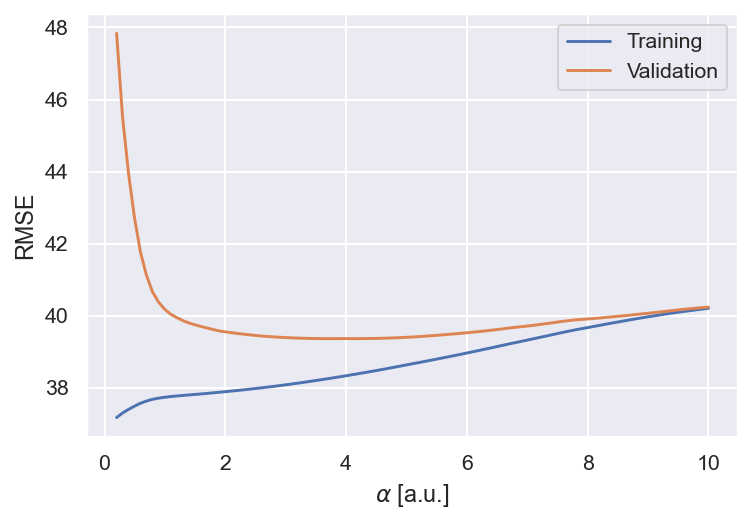

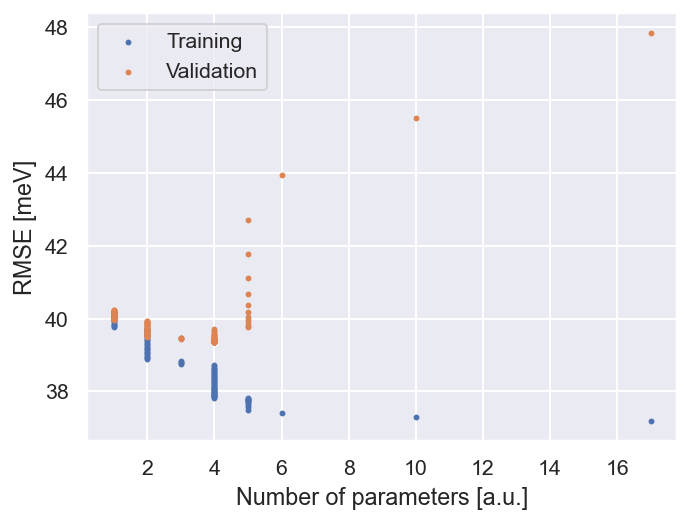

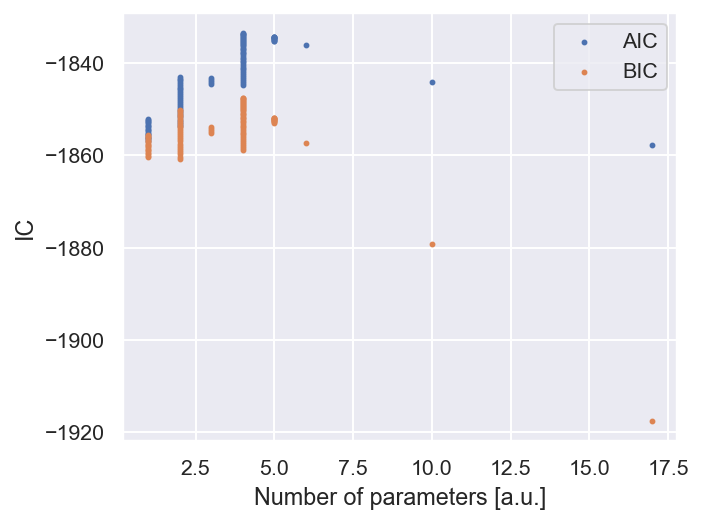

In [13]:
fig_rmse = plt.figure()
plt.plot(alpha_list, rmse_train_list, label='Training')
plt.plot(alpha_list, rmse_valid_list, label='Validation')

plt.xlabel(r'$\alpha$ [a.u.]')
plt.ylabel('RMSE')
plt.legend()
# plt.xlim(0.5,10)
# plt.ylim(35,45)

fig_rmse_vs_params = plt.figure(figsize=(6.4*0.8, 4.8*0.8))
plt.scatter(nbr_params_list, rmse_train_list, 4, label='Training')
plt.scatter(nbr_params_list, rmse_valid_list, 4, label='Validation')

plt.xlabel(r'Number of parameters [a.u.]')
plt.ylabel('RMSE [meV]')
plt.legend()
plt.tight_layout()
plt.savefig('Lasso_RMSE.pdf')

fig_IC = plt.figure(figsize=(6.4*0.8, 4.8*0.8))
plt.scatter(nbr_params_list, aic_list, 4, label='AIC')
plt.scatter(nbr_params_list, bic_list, 4, label='BIC')

plt.xlabel(r'Number of parameters [a.u.]')
plt.ylabel('IC')
plt.legend()
plt.tight_layout()
plt.savefig('Lasso_IC.pdf')


In [14]:

lmb = 100
ardr = linear_model.ARDRegression(threshold_lambda=lmb, fit_intercept=False)
ardr.fit(x_stand, y)
params = ardr.coef_
print(sum(params != 0))


4


In [15]:


def run_cv_ARDR(A, y, threshold_lambda):
    cv = KFold(n_splits=10, shuffle=True, random_state=42)
    rmse_train = []
    rmse_test = []

    ardr = linear_model.ARDRegression(
        threshold_lambda=threshold_lambda, fit_intercept=False)

    for train_inds, test_inds in cv.split(A):
        A_train = A[train_inds]
        y_train = y[train_inds]
        A_test = A[test_inds]
        y_test = y[test_inds]

        ardr.fit(A_train, y_train)
        parameters = ardr.coef_

        rmse_train.append(compute_rmse(A_train, y_train, parameters))
        rmse_test.append(compute_rmse(A_test, y_test, parameters))

    data = dict()
    data['rmse_train'] = np.mean(rmse_train)
    data['rmse_train_std'] = np.std(rmse_train)
    data['rmse_validation'] = np.mean(rmse_test)
    data['rmse_validation_std'] = np.std(rmse_test)
    return data



In [16]:
# lambda_list = np.append(np.linspace( 0, 0.9,10),np.linspace(1,10000,50))
lambda_list = np.append(np.linspace(0, 0.5, 100), np.linspace(1, 200, 20))
aic_list = []
bic_list = []
rmse_train_list = []
rmse_valid_list = []
std_train_list = []
std_valid_list = []
mse_list = []
nbr_params_list = []

y_stand = y
# y_stand=(y-np.mean(y))/np.std(y)
# A_stand=(x-np.mean(y))/np.std(y)

save_params = []

A = x_stand
for threshold_lambda in lambda_list:

    # print(sum(params!=0))

    cv_data = run_cv_ARDR(A, y_stand, threshold_lambda)
    ardr = linear_model.ARDRegression(
        threshold_lambda=threshold_lambda, fit_intercept=False)
    ardr.fit(A, y_stand)
    params = ardr.coef_
    aic, bic = get_aic_bic_sparse(A, y_stand, params)

    nbr_params_list.append(sum(params != 0))

    if sum(params != 0) == 4:
        save_params.append(params[1:5])
        # save_params.append(np.where(params!=0))

    aic_list.append(aic)
    bic_list.append(bic)
    rmse_train_list.append(cv_data.get('rmse_train'))
    rmse_valid_list.append(cv_data.get('rmse_validation'))
    std_train_list.append(cv_data.get('rmse_train_std'))
    std_valid_list.append(cv_data.get('rmse_validation_std'))



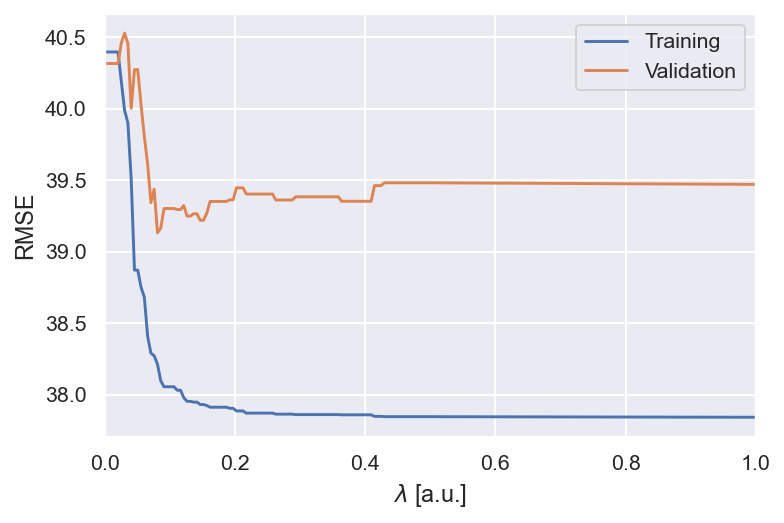

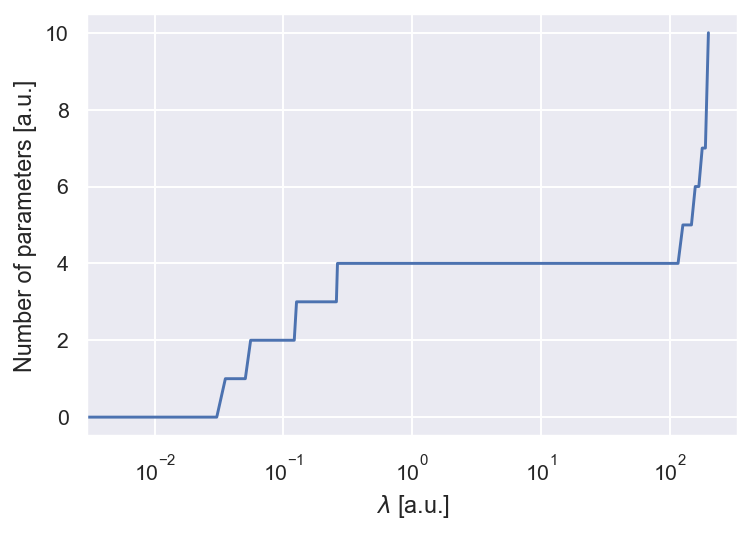

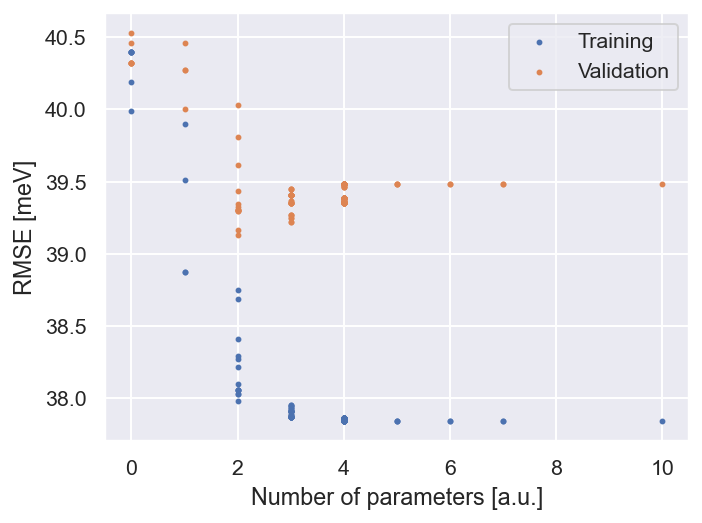

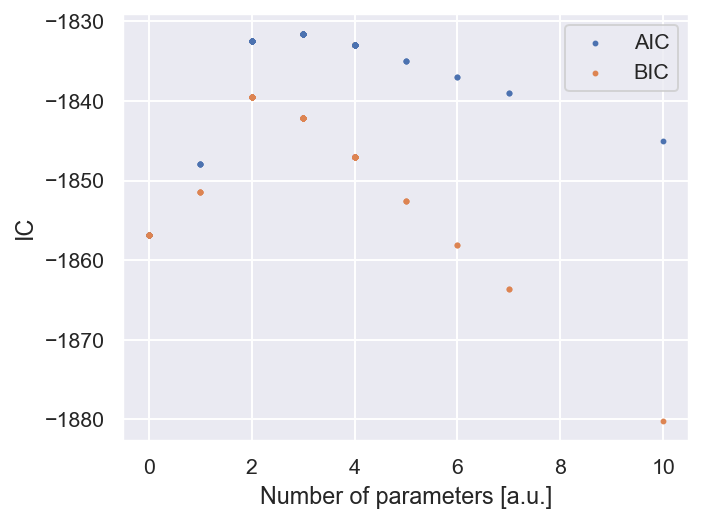

In [17]:
fig_rmse = plt.figure()
plt.plot(lambda_list, rmse_train_list, label='Training')
plt.plot(lambda_list, rmse_valid_list, label='Validation')

plt.xlabel(r'$\lambda$ [a.u.]')
plt.ylabel('RMSE')
plt.legend()
plt.xlim(0, 1)
# plt.ylim(35,45)

fig_lambda_params = plt.figure()
plt.semilogx(lambda_list, nbr_params_list)

plt.xlabel(r'$\lambda$ [a.u.]')
plt.ylabel('Number of parameters [a.u.]')
# plt.xlim(0,1)

fig_rmse_vs_params = plt.figure(figsize=(6.4*0.8, 4.8*0.8))
plt.scatter(nbr_params_list, rmse_train_list, 4, label='Training')
plt.scatter(nbr_params_list, rmse_valid_list, 4, label='Validation')

plt.xlabel(r'Number of parameters [a.u.]')
plt.ylabel('RMSE [meV]')
plt.legend()
plt.tight_layout()
plt.savefig('ARDR_RMSE.pdf')

fig_IC = plt.figure(figsize=(6.4*0.8, 4.8*0.8))
plt.scatter(nbr_params_list, aic_list, 4, label='AIC')
plt.scatter(nbr_params_list, bic_list, 4, label='BIC')

plt.xlabel(r'Number of parameters [a.u.]')
plt.ylabel('IC')
plt.legend()
plt.tight_layout()
plt.savefig('ARDR_IC.pdf')


 Task 4: Bayesian Cluster expansion   (7p)


In [18]:

# Get new cluster space with cutoffs
x = []

# setup CS
cutoffs = [12.0, 6.0]
prim = db.get(1).toatoms()
cs = ClusterSpace(prim, cutoffs=cutoffs, chemical_symbols=['Ag', 'Pd'])

for i, row in enumerate(db.select()):
    # get cluster-vector for a given atoms object
    atoms = row.toatoms()
    x.append(cs.get_cluster_vector(atoms))

x = np.array(x)


In [19]:
# define priors and likelihood


def mean_mode_2_IG_alpha_beta(mean, mode):
    alpha = (mode + mean)/(mean-mode)
    beta = (2 * mode * mean)/(mean-mode)
    return alpha, beta


a0_sig, b0_sig = mean_mode_2_IG_alpha_beta(100, 1)
a0_alpha, b0_alpha = mean_mode_2_IG_alpha_beta(2500, 25)


def log_prior(j, sigma2, alpha2, nP):
    return -0.5*nP*np.log(alpha2)-0.5*np.sum(j**2)/alpha2 + invgamma.logpdf(sigma2, a=a0_sig, scale=b0_sig) + invgamma.logpdf(alpha2, a=a0_alpha, scale=b0_alpha)


def log_likelihood(model, sigma2, data):
    return -np.sum((model-data)**2)/(2*sigma2)-0.5*len(data)*np.log(sigma2)


def log_posterior(params, A, data, nP):
    j = params[:nP]
    sigma2 = params[nP]
    alpha2 = params[nP+1]

    model = np.matmul(A, j)

    lp = log_prior(j, sigma2, alpha2, nP)
    if not np.isfinite(lp):
        return -np.inf

    return log_likelihood(model, sigma2, data)+lp



In [20]:
ndim, nwalkers = x.shape[1]+2, 100
# start_pos = [70,0,0.1] + [1e-2,1e-2,1e-5]*np.random.randn(nwalkers, ndim)
start_pos = [0]*x.shape[1]+[10]*np.random.randn(nwalkers, ndim-2)
start_pos = np.append(start_pos, [7, 30]+[1e-1]
                      * np.random.randn(nwalkers, 2), axis=1)

steps = 5000


sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_posterior, args=(x, y, ndim-2))
sampler.run_mcmc(start_pos, steps, progress=True)


100%|██████████| 5000/5000 [02:28<00:00, 33.77it/s]


State([[-44.63918677 -35.50715223  26.24579268 ...   1.4195769    6.31554805
   30.07309756]
 [-45.19925379 -34.79479245  25.77958182 ...   2.10159244   6.72479162
   29.35376091]
 [-44.68483882 -35.48822138  25.86786383 ...   2.31625988   6.85616514
   31.11293763]
 ...
 [-44.91668355 -35.30499442  27.44945492 ...   0.27233749   7.03491525
   31.00065087]
 [-45.21152561 -35.55384894  26.77423604 ...   3.57499762   7.2918281
   31.80554477]
 [-45.99035688 -33.98781295  27.43070561 ...   1.70501281   6.99312351
   31.63993152]], log_prob=[-493.22323346 -499.79310377 -507.73081071 -487.91612691 -502.153426
 -496.56054634 -508.0347055  -501.35291135 -493.1669759  -500.36996974
 -494.48160201 -493.10874202 -504.53280923 -495.75449674 -499.14799174
 -494.48253437 -501.61485879 -503.84677861 -507.42539147 -487.23757313
 -502.64906968 -493.37371629 -499.95702134 -495.69526177 -497.22285703
 -498.47972478 -496.99055391 -501.5146048  -499.34463343 -501.88452116
 -495.6040914  -497.2113287  -499

In [21]:


def simple_mcmc_analysis(sampler, par, label, burn_in, chain_from_file=False):

    if not chain_from_file:
        print(
            f'Mean acceptance fraction: {np.mean(sampler.acceptance_fraction):0.3f}')
    # discard the first 'burn_in' samples

    # thinning means that you only keep every nth sample. E.g. thinning=10 -> keep every 10th sample.
    # This can be useful for reducing long autocorrelation lenghts in a chain. However, thinning is expensive.
    # A thinned chain must be run E.g. 10x longer to reach the desired number of samples.
    # One can argue that thinning is not an advantageous strategy. So keep thinning = 1
    thinning = 1
    flat_mcmc_samples = sampler.get_chain(
        discard=burn_in, thin=thinning, flat=True)
    print(f'Discarding {nwalkers*burn_in} steps as burn-in')
    print(f'Chain length:{len(flat_mcmc_samples)}')

    fig1 = plt.figure()
    plt.plot(flat_mcmc_samples[:, par], color='gray', alpha=0.7)
    plt.xlabel('Sample')
    plt.ylabel(label)
    plt.xlim(0, len(flat_mcmc_samples))

    return flat_mcmc_samples



Mean acceptance fraction: 0.253
Discarding 300000 steps as burn-in
Chain length:200000


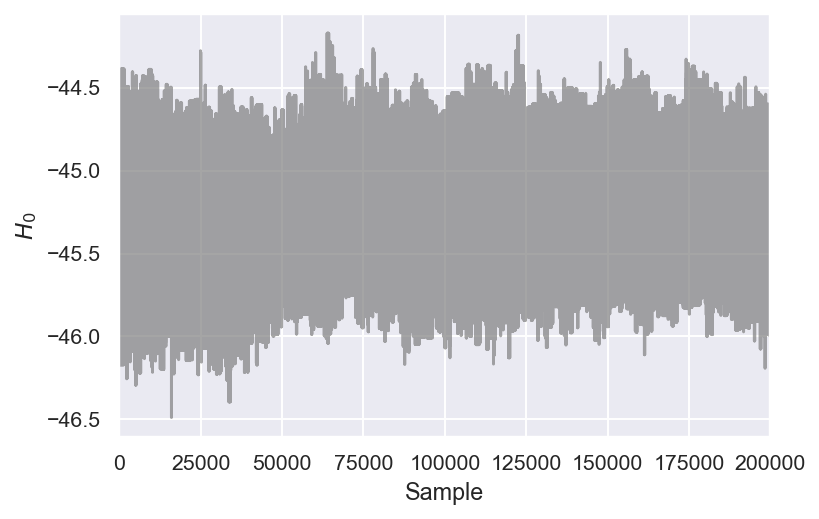

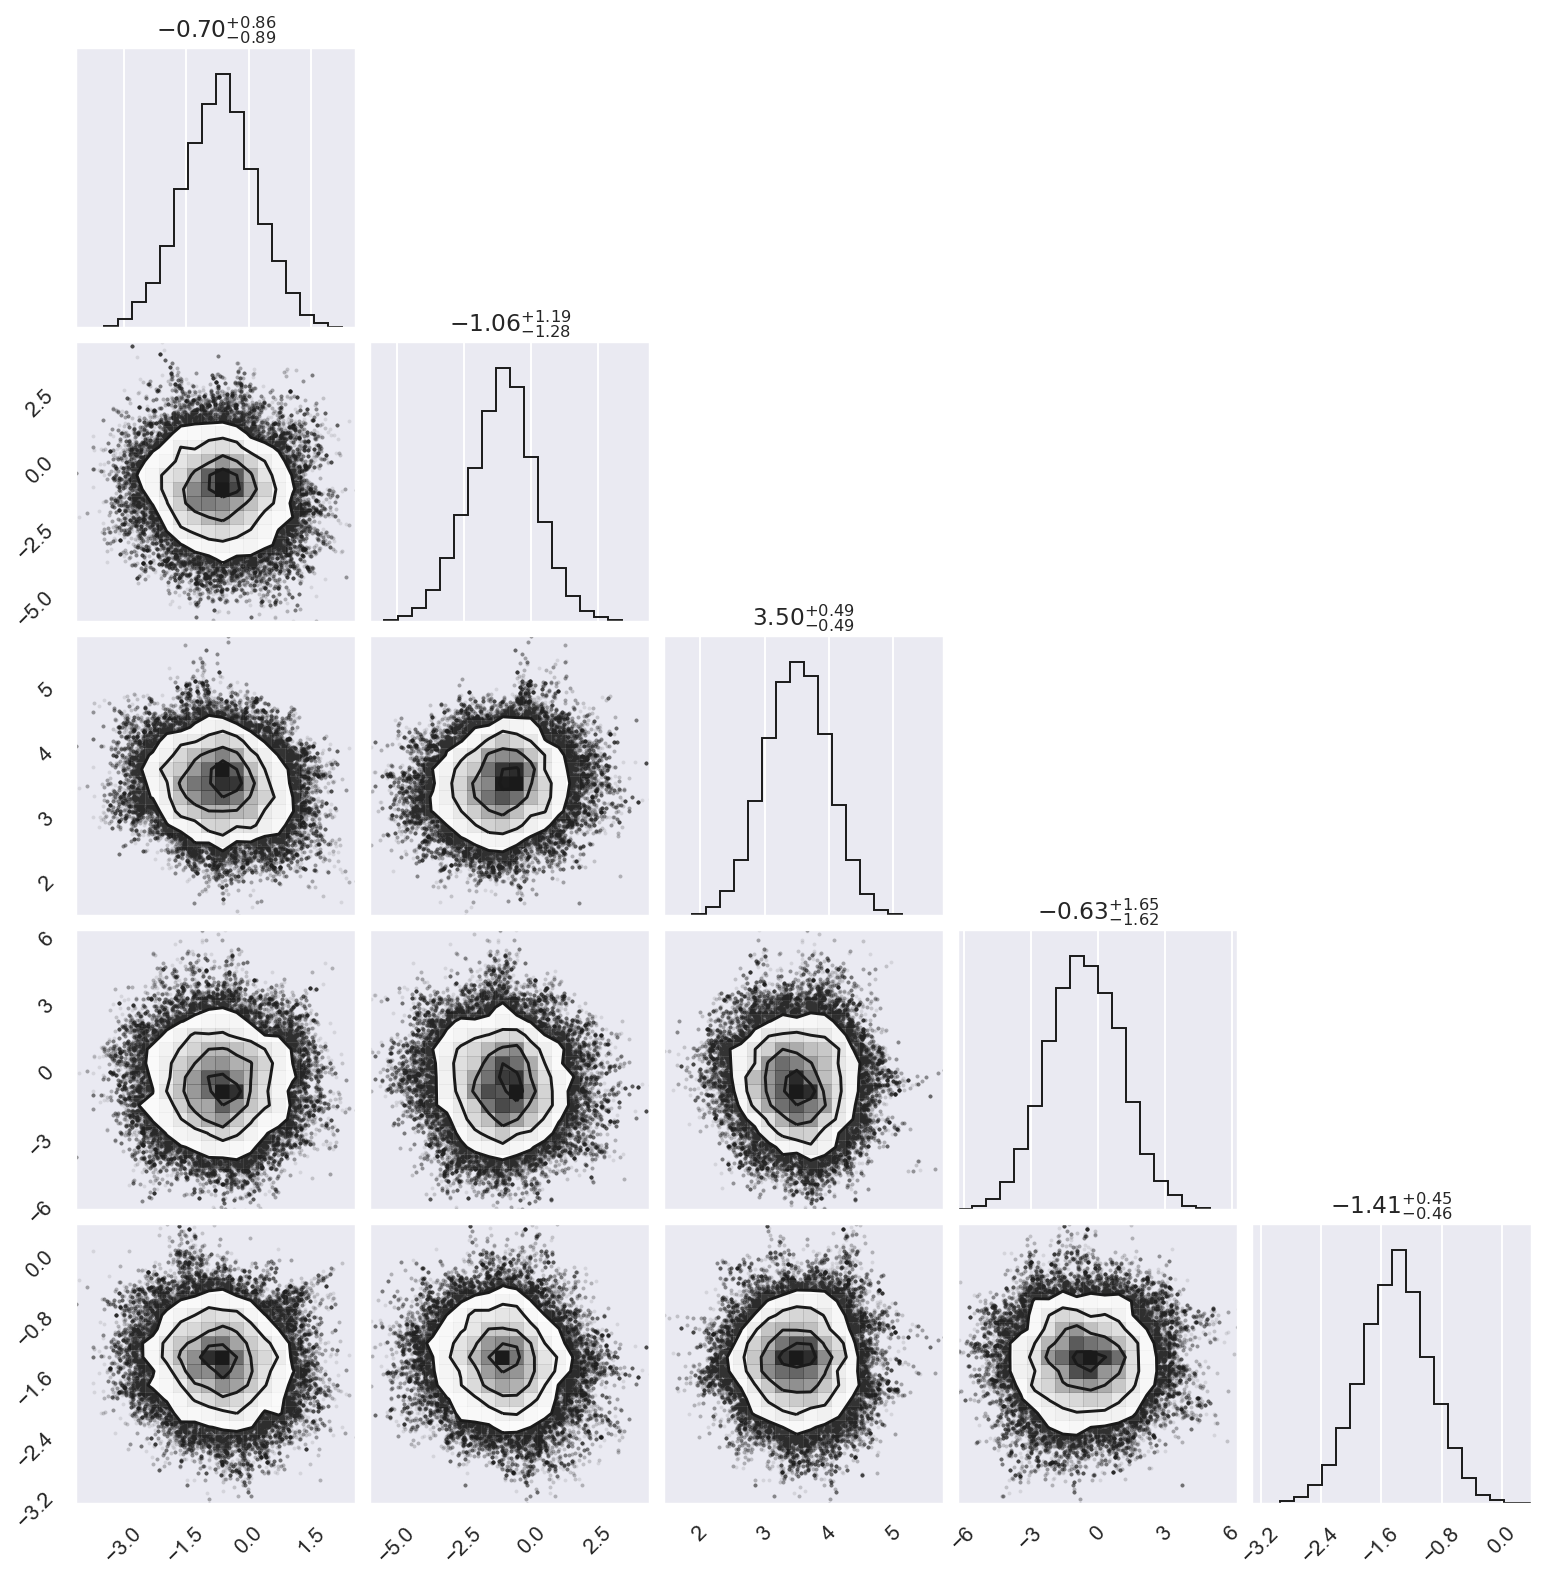

In [22]:
burn_in = 3000

flat_mcmc_samples = simple_mcmc_analysis(
    sampler, par=0, label=f'$H_0$', burn_in=burn_in)

fig = corner.corner(flat_mcmc_samples[:, 5:10], show_titles=True)


In [23]:
db_gs = connect('structures/ground_state_candidates.db')

x_gs = []

for i, row in enumerate(db_gs.select()):
    atoms = row.toatoms()
    x_gs.append(cs.get_cluster_vector(atoms))

x_gs = np.array(x_gs)

parameters = run_OLS_fit(x, y)
E_cand = np.matmul(x_gs, parameters)

gs_index = np.argmin(E_cand)
print(gs_index)
for i, row in enumerate(db_gs.select()):
    if i == gs_index:
        view(row.toatoms())


6


[0.00000e+00 3.94000e-03 1.42980e-01 0.00000e+00 0.00000e+00 2.18040e-01
 4.94825e-01 3.83650e-02 8.20150e-02 1.88450e-02 1.00000e-05 9.80000e-04]
6


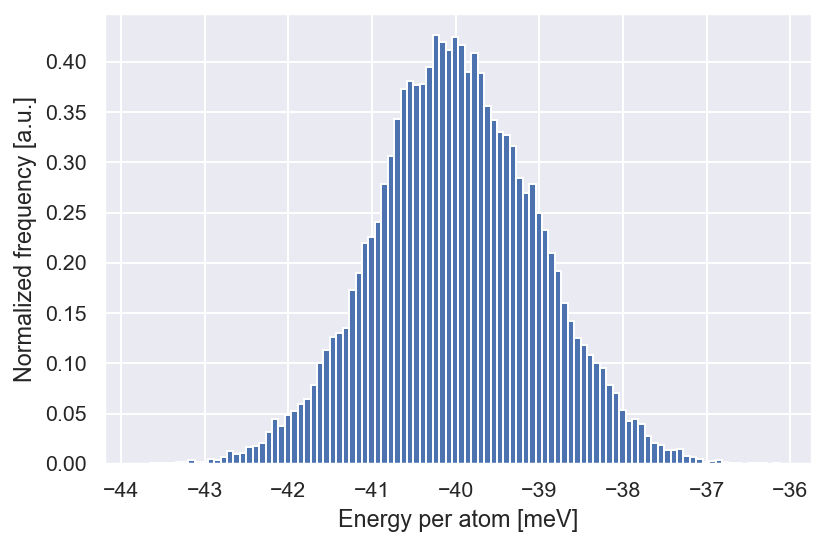

In [24]:

# Calculate lowest energy candidate for each sample,
# save lowest energy for each sample.

E_gs = []
gs_freq = np.zeros(x_gs.shape[0])

for i in range(len(flat_mcmc_samples[:, 0])):
    E = np.matmul(x_gs, flat_mcmc_samples[i, :33])
    index = np.argmin(E)
    E_gs.append(E[index])
    gs_freq[index] += 1

print(gs_freq/np.sum(gs_freq))
plt.hist(E_gs, bins=100,density=True)
plt.xlabel('Energy per atom [meV]')
plt.ylabel('Normalized frequency [a.u.]')
plt.tight_layout()
plt.savefig('E_hist.pdf')

gs_index_bayes = np.argmax(gs_freq)

for i, row in enumerate(db_gs.select()):
    if i == gs_index_bayes:
        view(row.toatoms())
print(gs_index_bayes)

# Frequency of being the lowest is converted to probability of the same.

# Plot the distribution of lowest energies.


<ErrorbarContainer object of 3 artists>

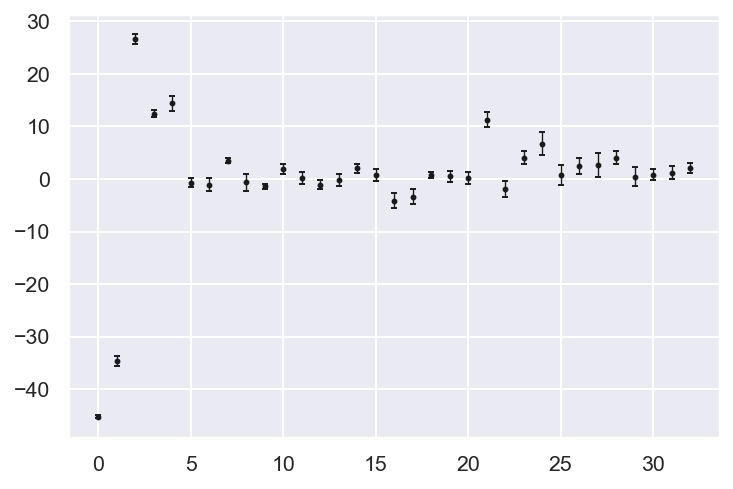

In [26]:
plt.errorbar(range(33), np.mean(flat_mcmc_samples[:, :33], axis=0), yerr=np.std(
    flat_mcmc_samples[:, :33], axis=0), fmt='.k', capsize=1.5, linewidth=0.7, markersize=4)
# plt.scatter(range(33),parameters)


In [27]:
cs.get_cluster_vector(atoms).shape


(33,)

In [28]:
radii_2 = [1.4460, 2.0450, 2.5046, 2.8921, 3.2334, 3.5420, 3.8258, 4.0900, 4.3381,
           4.3381, 4.5728, 4.7960, 5.0092, 5.2137, 5.2137, 5.6005, 5.7841, 5.9621, 5.9621]
radii_3 = [1.6697, 1.8915, 1.9280, 2.0217, 2.3077, 2.5028,
           2.6515, 2.6750, 2.7165, 2.8921, 3.0404, 3.3395]


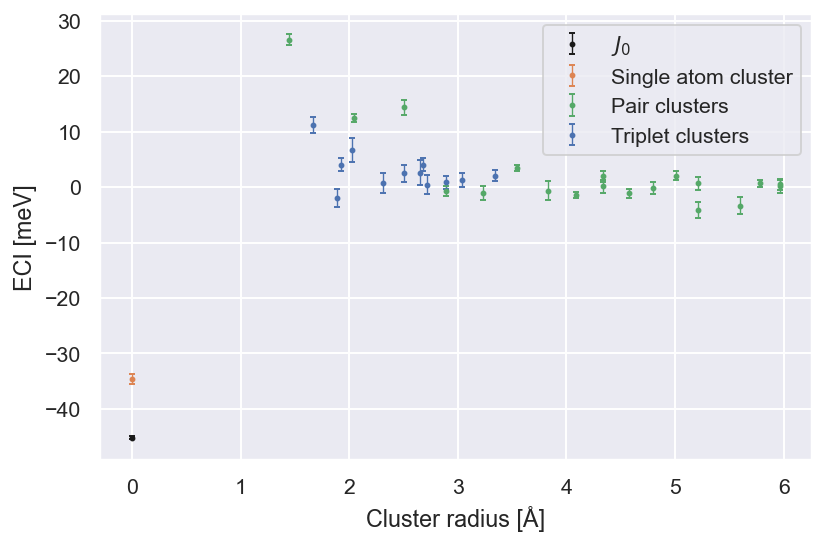

In [29]:
plt.errorbar([0], np.mean(flat_mcmc_samples[:, 0], axis=0), yerr=np.std(
    flat_mcmc_samples[:, 0], axis=0), fmt='.k', capsize=1.5, linewidth=0.7, markersize=4,label=r'$J_0$')
plt.errorbar([0], np.mean(flat_mcmc_samples[:, 1], axis=0), yerr=np.std(
    flat_mcmc_samples[:, 1], axis=0), fmt='.C1', capsize=1.5, linewidth=0.7, markersize=4,label='Single atom cluster')

plt.errorbar(radii_2, np.mean(flat_mcmc_samples[:, 2:21], axis=0), yerr=np.std(
    flat_mcmc_samples[:, 2:21], axis=0), fmt='.C2', capsize=1.5, linewidth=0.7, markersize=4,label='Pair clusters')
plt.errorbar(radii_3, np.mean(flat_mcmc_samples[:, 21:33], axis=0), yerr=np.std(
    flat_mcmc_samples[:, 21:33], axis=0), fmt='.C0', capsize=1.5, linewidth=0.7, markersize=4,label='Triplet clusters')
plt.legend()
plt.xlabel('Cluster radius [Å]')
plt.ylabel('ECI [meV]')
plt.tight_layout()
plt.savefig('ECIs.pdf')



In [33]:
Es = []
E_gs = []

for i in range(len(flat_mcmc_samples[:, 0])):
    E = np.matmul(x_gs, flat_mcmc_samples[i, :33])
    Es.append(E)
Es = np.array(Es)

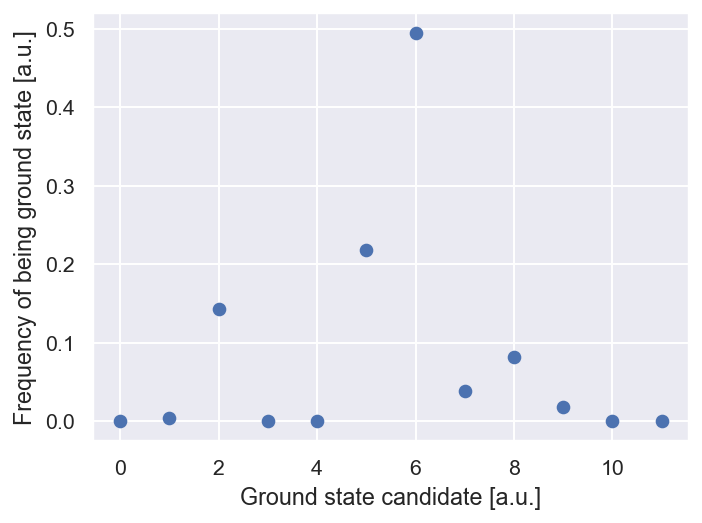

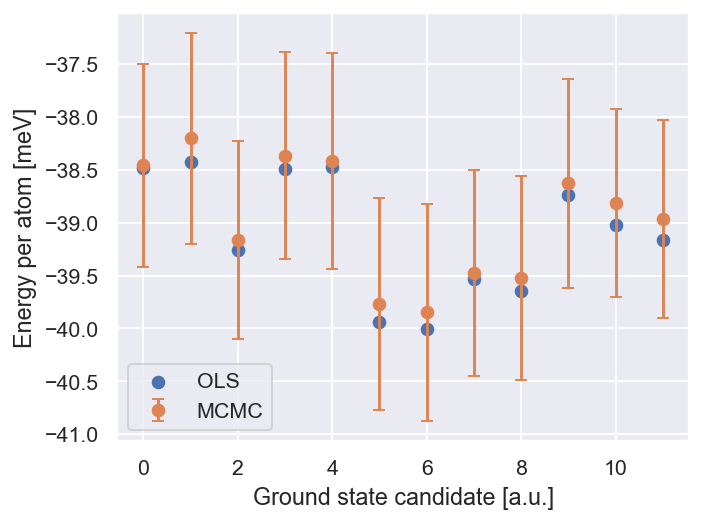

In [34]:
plt.figure(figsize=(6.4*0.8, 4.8*0.8))
plt.scatter(range(12),gs_freq/np.sum(gs_freq))
plt.xlabel('Ground state candidate [a.u.]')
plt.ylabel('Frequency of being ground state [a.u.]')
plt.tight_layout()
plt.savefig('gs_freq_mcmc.pdf')
plt.figure(figsize=(6.4*0.8, 4.8*0.8))
plt.errorbar(range(12),np.mean(Es,axis=0),np.std(Es,axis=0), fmt='.C1', capsize=3, linewidth=1.5, markersize=12,label='MCMC')
plt.scatter(range(12),E_cand,label='OLS')
# plt.scatter(range(12),gs_freq/np.sum(gs_freq),'.k',)
plt.legend()
plt.xlabel('Ground state candidate [a.u.]')
plt.ylabel('Energy per atom [meV]')
plt.tight_layout()
plt.savefig('gs_Energy_OLS_v_MCMC.pdf')